<a href="https://colab.research.google.com/github/msvt37/Unit-10-A_Yen_For_Future_HW/blob/main/time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(Path("/content/drive/MyDrive/Colab Notebooks/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0


In [5]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

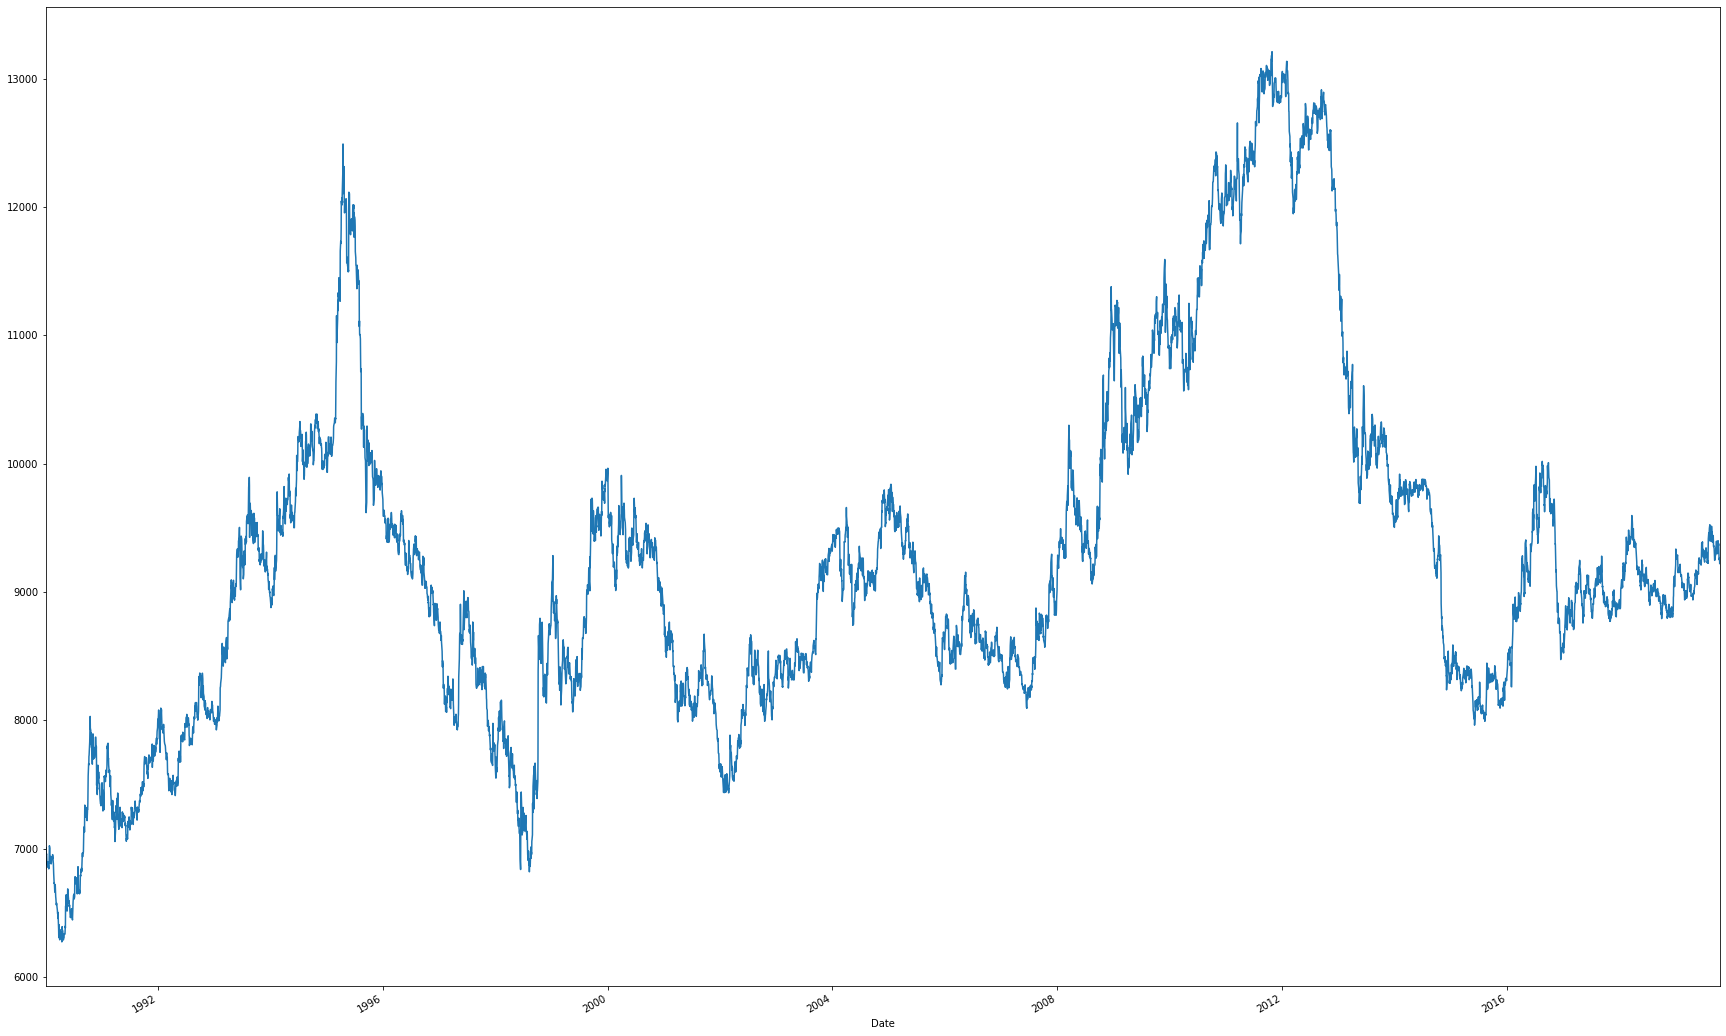

In [6]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot(figsize = (30,20)).autoscale(axis='x', tight=True)

Looking at the data plot above, there appears to be an upward trend in the Settle price when you remove noise over the entire period.  In the short-term, there is fair amount of volatility in the pricing as there are a number of large increases, and corresponding drops. Between the period of 1998 to 2008, there appears to be a less volatility in the price.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

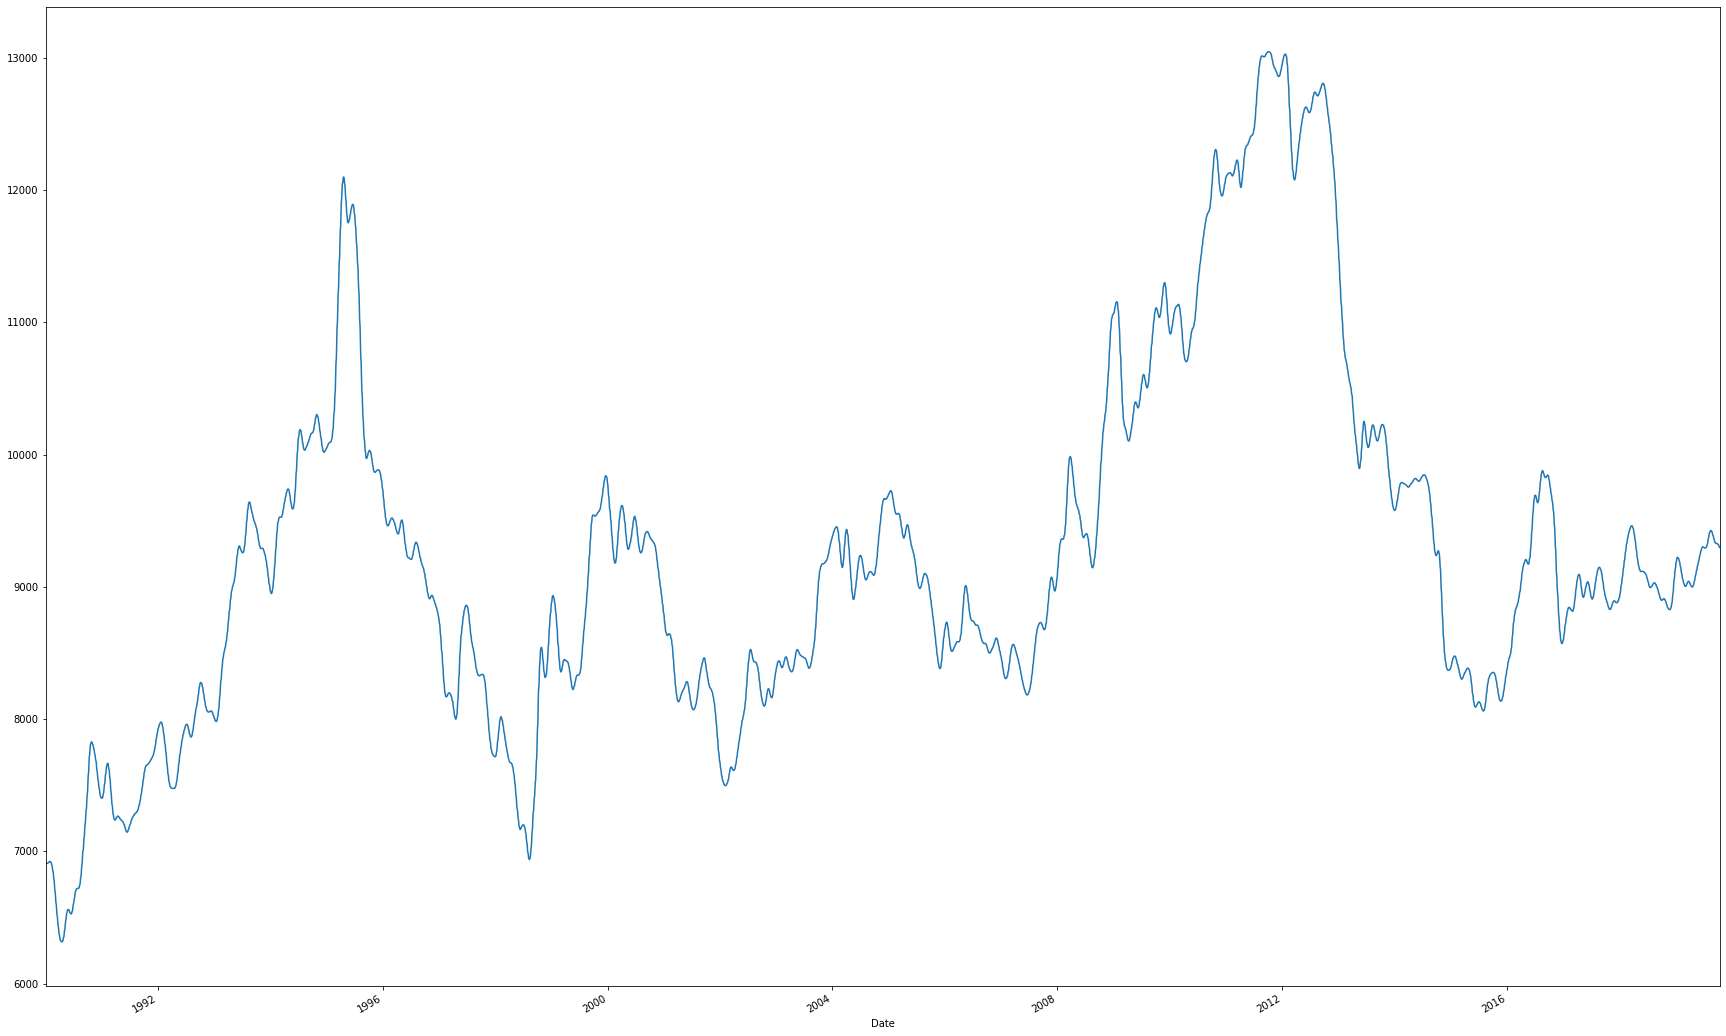

In [8]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])
ts_trend.plot(figsize = (30,20)).autoscale(axis='x', tight=True)


In [9]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
settle_price_df = pd.DataFrame(yen_futures['Settle'])
settle_price_df['Noise'] = ts_noise
settle_price_df['Trend'] = ts_trend

In [10]:
# Plot the Settle Price vs. the Trend for 2015 to the present.
# Chose to use plotly to enable / disable plots for better visualization.
fig = go.Figure()
fig.add_trace(go.Scatter(x=settle_price_df.index, y=settle_price_df['Settle'], mode='lines', name='Settle Price'))
fig.add_trace(go.Scatter(x=settle_price_df.index, y=settle_price_df['Trend'], mode='lines', name='HP Trend'))

In [11]:
# Plot the Settle Noise
fig = go.Figure()
fig.add_trace(go.Scatter(x=settle_price_df.index, y=settle_price_df['Noise'], mode='lines', name='HP Noise'))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [12]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [13]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [14]:
# Output model summary results:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 27 Apr 2021   AIC                          15798.142
Time:                        01:44:44   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3063      1.277     -0.240      0.810      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2947      1.277      0.231      0.817      -2.208       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3339           +0.0000j            3.3339            0.5000
AR.2         -157.1560           +0.0000j          157.1560            0.5000
MA.1           -3.3927           +0.0000j            3.3927            0.5000
-----------------------------------------------------------------------------
"""

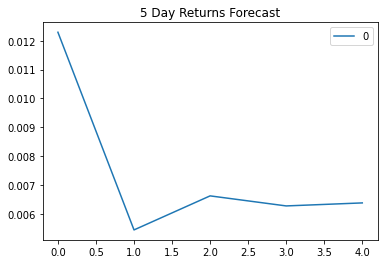

In [15]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

For this model, our P values are larger than .05 and are therefore insignificant.  This model does not appear to have value. 

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [16]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model2 = ARIMA(yen_futures['Settle'], order=(5, 1, 1))

# Fit the model
results2 = model2.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [17]:
# Output model summary results:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Tue, 27 Apr 2021   AIC                          83905.238
Time:                        01:45:22   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2821      0.699      0.404      0.687      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2972      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8917           -1.3786j            2.3408           -0.1002
AR.2            1.8917           +1.3786j            2.3408            0.1002
AR.3           -2.2698           -3.0208j            3.7785           -0.3526
AR.4           -2.2698           +3.0208j            3.7785            0.3526
AR.5          -11.0605           -0.0000j           11.0605           -0.5000
MA.1            3.3650           +0.0000j            3.3650            0.0000
-----------------------------------------------------------------------------
"""

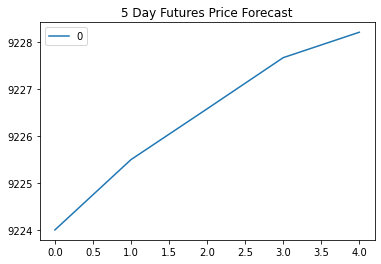

In [18]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results2.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

Like the ARMA model above this, our ARIMA model is generating p values larger that .05 for the coefficients and can be considered insignificant.  

The model is predicting a modest gain over the 5 day period. 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [20]:
!pip install arch
import arch as arch
from arch import arch_model

     |████████████████████████████████| 808kB 10.6MB/s 


In [21]:
# Estimate a GARCH model:
model3 = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results3 = model3.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7487.064161989989
Iteration:      2,   Func. Count:     15,   Neg. LLF: 7486.047101908487
Iteration:      3,   Func. Count:     24,   Neg. LLF: 7485.833691292897
Iteration:      4,   Func. Count:     31,   Neg. LLF: 7471.893782597834
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7469.862886697916
Iteration:      6,   Func. Count:     45,   Neg. LLF: 7468.043030886385
Iteration:      7,   Func. Count:     53,   Neg. LLF: 7467.366978281441
Iteration:      8,   Func. Count:     59,   Neg. LLF: 7462.418430385662
Iteration:      9,   Func. Count:     65,   Neg. LLF: 7462.21415700937
Iteration:     10,   Func. Count:     71,   Neg. LLF: 7462.021593960289
Iteration:     11,   Func. Count:     77,   Neg. LLF: 7461.935965796787
Iteration:     12,   Func. Count:     83,   Neg. LLF: 7461.927898453685
Iteration:     13,   Func. Count:     89,   Neg. LLF: 7461.92764357386
Iteration:     14,   Func. Count:     95,   Neg. LLF: 7461.9276400

In [22]:
# Summarize the model results
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Tue, Apr 27 2021   Df Residuals:                     7514
Time:                        01:46:05   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [23]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [24]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results3.forecast(start=last_day, horizon=forecast_horizon)

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning:


The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.




In [25]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [26]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


In [27]:
# Plot the final forecast
fig = go.Figure()
fig.add_trace(go.Scatter(x=final.index, y=final['2019-10-15'], mode='lines', name='GARCH'))

---

# Conclusions

Based on your time series analysis, would you buy the yen now? I do not feel confident enough in this model to purchase the Yen now.

Is the risk of the yen expected to increase or decrease? Increase

Based on the model evaluation, would you feel confident in using these models for trading?  No, the models do not appear to have significant applicablity to predicting future activity.